In [1]:
from music21 import corpus, stream, note
import tensorflow as tf
import math
import random
import functools
import numpy as np

In [2]:
# number of voices
NUM_VOICES = 4

#number of output classes, i.e. half tone differences to melody
NUM_CLASSES = 26

# duration of time tick in beats. 1=quarter, 0.25=16th 
TIME_TICK = 0.25

In [3]:
def extractMelody(music):
    min_midi = 256
    max_midi = 0
    melody = []
    currentOffset = 0
    for n in music.parts[0].flat.notes:
        #print("%s: %s %s %s" % (n.pitch.midi, n.pitch, n.offset, n.duration.quarterLength))
        while (n.offset > currentOffset):
            # insert breaks
            melody.append([currentOffset, 0, 1])
            currentOffset += TIME_TICK;
        noteTicks = math.floor(n.duration.quarterLength / TIME_TICK)
        min_midi = min(min_midi, n.pitch.midi)
        max_midi = max(max_midi, n.pitch.midi)
        for ticks in range(0, noteTicks):
            if (ticks == 0):
                melody.append([currentOffset, n.pitch.midi, 1])
            else:
                melody.append([currentOffset, n.pitch.midi, 0])
            currentOffset += TIME_TICK;
    #print("Melody min/max midi pitch: %d/%d" % (min_midi, max_midi))
    return melody

In [4]:
# calculate difference between melody and voice in halftones. 1: same halftone, 2: one halftone below 
# Limit to NUM_CLASSES. If the difference is greater, shift the voice by octaves.
def noteDifference(melody, voice):
    diff = melody - voice
    if diff < 0:  raise Exception("Error: voice above melody")
    # -1 for adding 1 below, additionl -1 so that diff can be index 
    while (diff > NUM_CLASSES - 2):
        diff -= 12
    return diff + 1

In [5]:
def extractVoices(melody, music):
    for partIndex in range(1, len(music.parts)):
        partNotes = music.parts[partIndex].flat.notes
        noteIndex = 0;
        maxNoteIndex = len(partNotes)
        
        for n in melody:
            #print(n)
            currentOffset = n[0]
            if (noteIndex < maxNoteIndex):
                voiceNote = partNotes[noteIndex]
                if (voiceNote.offset + voiceNote.duration.quarterLength <= currentOffset):
                    # skip to next note
                    noteIndex += 1
            if (noteIndex < maxNoteIndex):                
                voiceNote = partNotes[noteIndex]
                if (voiceNote.offset == currentOffset):
                    # new note
                    n.append(noteDifference(n[1], voiceNote.pitch.midi))
                    n.append(1)
                elif (voiceNote.offset < currentOffset):
                    # continuing note
                    n.append(noteDifference(n[1], voiceNote.pitch.midi))
                    n.append(0)
                else:
                    # between notes or behind last note, fill with empty 
                    n.append(0)
                    n.append(1)

In [6]:
songs = []
streams = []
for name in corpus.chorales.Iterator(returnType='filename'):
    song = corpus.parse(name)
    key = song.analyze('key')
    highestTime = song.highestTime
    if len(song.parts) == 4 and highestTime < 68: 
        # and song.parts[0].flat.getTimeSignatures()[0].numerator == 3 and key.mode == 'major' 
        
        song.transpose(song.analyze('key').sharps, inPlace = True)
        #song.show()
        try:
            notes = extractMelody(song)
            extractVoices(notes, song)
            songs.append(notes)
            streams.append(song)
            print('%3d: %s: %s, %d, %s voices, duration: %s' % (
                len(songs), name, key, song.parts[0].flat.getTimeSignatures()[0].numerator, len(song.parts), highestTime))
            #song.show()
            #song.show('midi')
            
        except Exception as E:
            print(E)
            print("Error: %s not expected format, ignored" % name)
    #print(notes)

  1: bach/bwv153.1: a minor, 4, 4 voices, duration: 56.0
  2: bach/bwv86.6: E major, 4, 4 voices, duration: 56.0
  3: bach/bwv281: F major, 4, 4 voices, duration: 32.0
  4: bach/bwv248.12-2: G major, 4, 4 voices, duration: 64.0
  5: bach/bwv65.2: a minor, 3, 4 voices, duration: 49.0
  6: bach/bwv277: d minor, 4, 4 voices, duration: 49.0
  7: bach/bwv318: G major, 4, 4 voices, duration: 52.0
  8: bach/bwv351: g minor, 4, 4 voices, duration: 36.0
Error: voice above melody
Error: bach/bwv302 not expected format, ignored
Error: voice above melody
Error: bach/bwv153.5 not expected format, ignored
  9: bach/bwv28.6: a minor, 4, 4 voices, duration: 64.0
 10: bach/bwv415: D major, 4, 4 voices, duration: 64.0
 11: bach/bwv20.11: F major, 4, 4 voices, duration: 64.0
 12: bach/bwv308: B- major, 4, 4 voices, duration: 56.0
 13: bach/bwv36.8-2: b minor, 4, 4 voices, duration: 32.0
 14: bach/bwv363: e minor, 4, 4 voices, duration: 48.0
 15: bach/bwv256: a minor, 4, 4 voices, duration: 56.0
 16: bach

131: bach/bwv338: a minor, 4, 4 voices, duration: 56.0
132: bach/bwv391: G major, 3, 4 voices, duration: 66.0
133: bach/bwv346: C major, 4, 4 voices, duration: 61.0
134: bach/bwv290: F major, 4, 4 voices, duration: 32.0
135: bach/bwv316: g minor, 4, 4 voices, duration: 64.0
136: bach/bwv333: g minor, 4, 4 voices, duration: 56.0
137: bach/bwv286: a minor, 4, 4 voices, duration: 24.0
138: bach/bwv273: B- major, 4, 4 voices, duration: 40.0
139: bach/bwv296: G major, 4, 4 voices, duration: 56.0
140: bach/bwv297: d minor, 4, 4 voices, duration: 45.0
141: bach/bwv154.3: A major, 4, 4 voices, duration: 64.0
142: bach/bwv423: g minor, 4, 4 voices, duration: 64.0
143: bach/bwv310: e minor, 4, 4 voices, duration: 40.0
144: bach/bwv292: C major, 4, 4 voices, duration: 56.0
145: bach/bwv396: a minor, 4, 4 voices, duration: 32.0
146: bach/bwv435: e minor, 4, 4 voices, duration: 44.0
147: bach/bwv357: c minor, 4, 4 voices, duration: 64.0
Error: voice above melody
Error: bach/bwv432 not expected form

In [7]:
print(len(songs))

211


In [8]:
def createStream(music, numVoices=4):
    sc = stream.Score()
    notes = []
    for v in range(0, numVoices):
        sc.insert(0, stream.Part())
        notes.append(None)

    melodyPitchIndex = 1
        
    for tick in music:
        for voice in range (0, numVoices):
            part = sc.parts[voice]
            pitchIndex = 1 + voice * 2
            strikeIndex = 1 + voice * 2 + 1
            # extend note
            if notes[voice] != None and tick[strikeIndex] == 0:
                notes[voice].quarterLength += TIME_TICK
            
            if tick[strikeIndex] == 1:
                if (tick[pitchIndex]) > 0:
                    #create new note
                    n = note.Note()
                    notes[voice] = n
                    n.offset = tick[0]
                    if (voice == 0):
                        #melody voice
                        n.pitch.midi = tick[pitchIndex]
                    else:
                        #other voices relative to melody
                        n.pitch.midi = tick[melodyPitchIndex] - tick[pitchIndex] + 1
                    n.quarterLength = TIME_TICK
                    part.append(n)
                else:
                    n = note.Rest()
                    notes[voice] = n
                    n.offset = tick[0]
                    n.quarterLength = TIME_TICK
                    part.append(n)
    return sc
    
                        

In [9]:
# https://gist.github.com/danijar/61f9226f7ea498abce36187ddaf51ed5
# Example for my blog post at:
# http://danijar.com/introduction-to-recurrent-networks-in-tensorflow/
import functools

def lazy_property(function):
    attribute = '_' + function.__name__

    @property
    @functools.wraps(function)
    def wrapper(self):
        if not hasattr(self, attribute):
            setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return wrapper


class MusicAccompanistLearning:

    def __init__(self, data, seq_length, target, dropout, num_hidden=200, num_layers=1, NUM_VOICES = 4):
        self.data = data
        self.target = target
        self.dropout = dropout
        self._num_hidden = num_hidden
        self._num_layers = num_layers
        self.seq_length = seq_length
        self.prediction
        self.error
        self.optimize
        #self.update_states

    @lazy_property
    def prediction(self):
        # Recurrent network.
        #cells = [tf.nn.rnn_cell.BasicLSTMCell(self._num_hidden, state_is_tuple = True)] * self._num_hidden
        cells = []
        for layer in range (0, self._num_layers):
            #cells.append(tf.nn.rnn_cell.BasicLSTMCell(self._num_hidden, state_is_tuple = True)) # or GRUCell)
            # a lot of fluctuation (8th/16th) in the results between different possible notes.
            # this might be reduced by the peep holes?
            cells.append(tf.nn.rnn_cell.LSTMCell(
                self._num_hidden, state_is_tuple = True, use_peepholes=True))
        
        network = tf.contrib.rnn.MultiRNNCell(cells, state_is_tuple = True)
        #network = tf.contrib.rnn.GRUCell(self._num_hidden)
        
        # if state_is_tuple = TRue, does not work with undefined btch size
        #self.states = get_state_variables(data.shape[0], network)
        #state = tf.Variable(network.zero_states(data.shape[0], tf.float32), trainable=False)
        
        output, new_states = tf.nn.dynamic_rnn(network, data, dtype=tf.float32, 
                                               sequence_length=self.seq_length) #, initial_state=states)
        
        # Add an operation to update the train states with the last state tensors.
        # if state_is_tuple = True, does not work with undefined btch size
        # self.update_states = get_state_update_op(states, new_states)
        # self.update_states = states.assign(new_states)
        
        # Softmax layer for voices
        max_length = int(self.target.get_shape()[1])
        weight, bias = self._weight_and_bias(self._num_hidden, NUM_CLASSES * (NUM_VOICES - 1))
        # Flatten to apply same weights to all time steps.
        output = tf.reshape(output, [-1, self._num_hidden])
        prediction_voices = tf.matmul(output, weight) + bias
        prediction_voices = tf.nn.softmax(tf.reshape(prediction_voices, [-1, max_length, (NUM_VOICES - 1), NUM_CLASSES]))
        print("prediction_voices:", prediction_voices.shape)
        
        # strike layer for voices: 1 
        weight, bias = self._weight_and_bias(self._num_hidden, NUM_VOICES - 1)
        prediction_strike = tf.sigmoid(tf.reshape(tf.matmul(output, weight) + bias, [-1, max_length, NUM_VOICES - 1, 1]))
        print("prediction_strike:", prediction_strike.shape)
        
        prediction = tf.concat(axis = 3, values = [prediction_voices, prediction_strike])
        print("prediction:", prediction.shape)
        
        return prediction

    @lazy_property
    def cost(self):
        # Compute cross entropy for each frame.
        cross_entropy = target * tf.log(tf.clip_by_value(self.prediction, 1e-10, 1.0)) \
            + (1 - target) * tf.log(tf.clip_by_value(1 - self.prediction, 1e-10, 1.0))
        cross_entropy = -tf.reduce_sum(cross_entropy, [2, 3])
        # mask out padding. ToDo: also rests have target value of 0
        mask = tf.sign(tf.reduce_max(tf.abs(target), [2, 3]))
        cross_entropy *= mask
        # Average over actual sequence lengths.
        cross_entropy = tf.reduce_sum(cross_entropy, 1)
        cross_entropy /= tf.reduce_sum(mask, 1)
        return tf.reduce_mean(cross_entropy)        

    @lazy_property
    def optimize(self):
        learning_rate = 0.003
        optimizer = tf.train.RMSPropOptimizer(learning_rate)
        #optimizer = tf.train.AdamOptimizer(learning_rate)
        #optimizer = tf.train.MomentumOptimizer(learning_rate)
        return optimizer.minimize(self.cost)

    @lazy_property
    def error(self):
        mistakes = tf.not_equal(
            tf.argmax(self.target, 3), tf.argmax(self.prediction, 3))
        mistakes = tf.cast(mistakes, tf.float32)
        return tf.reduce_mean(tf.cast(mistakes, tf.float32))

    @staticmethod
    def _weight_and_bias(in_size, out_size, name_postfix=''):
        weight = tf.truncated_normal([in_size, out_size], stddev=0.01)
        bias = tf.constant(0.1, shape=[out_size])
        return tf.Variable(weight, name='weight' + name_postfix), tf.Variable(bias, name='bias' + name_postfix)


def read_dataset(songs, NUM_VOICES = 4):
    seq_length = []
    for song in songs: seq_length.append(len(song))
    max_seq_length = max(seq_length)

    print("max sequence length: ", max_seq_length)
    
    m = len(songs)  
    print("num samples: ", m)
    X=[]
    Y=[]
    for sg in songs:
        x=[]
        y=[]
        #print(sg)
        for tick in sg:
            #print(tick)
            melody = []
            # encode as halftones (2 octaves) above C-3 (59)
            oneHot = np.zeros(NUM_CLASSES)
            pitch = tick[1]
            # one-hot encode the pitch. A break is empty.
            if (pitch >= 59 and pitch < 83):
                oneHot[tick[1] - 59] = 1
            elif pitch != 0:
                print(pitch)
            
            # add strike
            melody = np.append(oneHot, tick[2])
            
            x.append(melody)
            
            voices = []
            for voice in range(NUM_VOICES - 1):
                voice_index = 3 + voice * 2
                oneHot = np.zeros(NUM_CLASSES)
                #print(tick)
                oneHot[tick[voice_index]] = 1
                # add strike
                voiceCode = np.append(oneHot, tick[voice_index + 1])
                #print(oneHot)
                voices.append(voiceCode)
            y.append(voices)
            #print("%s: %s -> %s" % (tick[0], tick[3], oneHot))
        # pad songs
        padding_length = max_seq_length - len(x)
        #print("padding:", padding_length)
        for i in range (0, padding_length):
            x.append([0] * (NUM_CLASSES + 1))
            voices = []
            for voice in range(NUM_VOICES - 1):
                voices.append(np.zeros(NUM_CLASSES + 1))
            y.append(voices)
        X.append(x)
        Y.append(y)   
    #print(Y[0])
    data = np.array(X)
    print("data: ", data.shape)
    target = np.array(Y)
    print("target: ", target.shape)
    dataset = {'data': data , 'target' : target, 'seq_length' : np.array(seq_length)}
    # ToDo: split training and test set already here. Generelization on the test set can only be evaluated manually, 
    # there is no "right" accompanying voice. 
    train, test = dataset, dataset
    return train, test


if __name__ == '__main__':
    tf.reset_default_graph()
    train, test = read_dataset(songs)
    _, length, input_size = train['data'].shape
    data = tf.placeholder(tf.float32, [None, length, input_size], name = "input")
    target = tf.placeholder(tf.float32, [None, length, NUM_VOICES - 1, NUM_CLASSES + 1], name = "target")
    seq_length = tf.placeholder(tf.float32, [None], name = "seq_length")
    dropout = tf.placeholder(tf.float32, name = "dropout")
    model = MusicAccompanistLearning(data, seq_length, target, dropout, num_hidden = 300, num_layers=3)
    sess = tf.Session()
    #sess.run(tf.initialize_all_variables())
    sess.run(tf.global_variables_initializer())

max sequence length:  264
num samples:  211
57
57
57
57
57
57
57
57
57
57
57
57
57
57
57
57
57
57
83
83
83
83
data:  (211, 264, 27)
target:  (211, 264, 3, 27)
prediction_voices: (?, 264, 3, 26)
prediction_strike: (?, 264, 3, 1)
prediction: (?, 264, 3, 27)


In [12]:
random.seed(1)
max_song = 189
for epoch in range(5000):
    batchsize = random.randint(8, 12)
    for batchnum in range(math.floor(max_song / batchsize)):
        batch_start = batchnum * batchsize
        batch_end = batchnum * batchsize + batchsize
        batch_end = min(max_song, batch_end)
        batch_data = train['data'][batch_start : batch_end]
        batch_target = train['target'][batch_start : batch_end]
        batch_seq_length = train['seq_length'][batch_start : batch_end]
        #batch = train #.sample(10)
        sess.run(model.optimize, {
            data: batch_data, target: batch_target, seq_length: batch_seq_length, dropout: 0.5})
        error_batch = sess.run(model.cost, {
            data: batch_data, target: batch_target, seq_length: batch_seq_length, dropout: 1})
        print('   Batch {:2d} {:2d}-{:2d} error {:3.3f}'.format(batchnum + 1, batch_start, batch_end, error_batch))
    #error = sess.run(model.error, {
    #    data: test['data'], target: test['target'], seq_length: test['seq_length'], dropout: 1})
    error = 0
    prediction = sess.run(model.prediction, {
        data: test['data'], target: test['target'], seq_length: test['seq_length'], dropout: 1})
    for i in range(10): #test['seq_length'][0]):
        targ = np.argmax(test['target'][0, i, 0, :NUM_CLASSES - 1])
        tstrike = test['target'][0, i, 0, NUM_CLASSES]
        pred = np.argmax(prediction[0, i, 0, :NUM_CLASSES - 1])
        predStrike = prediction[0, i, 0, NUM_CLASSES]
        print("%d %s (%.2f) - %.2f %s (%.2f)" % (
            tstrike, targ, prediction[0, i, 0, targ], predStrike, pred, prediction[0, i, 0, pred]))
        #print(batch['target'][0][0])
    print('Epoch {:2d} error {:3.1f}% --------------------------------'.format(epoch + 1, 100 * error))
            

   Batch  1  0- 9 error 14.544
   Batch  2  9-18 error 14.525
   Batch  3 18-27 error 14.499
   Batch  4 27-36 error 14.472
   Batch  5 36-45 error 14.429
   Batch  6 45-54 error 14.378
   Batch  7 54-63 error 14.293
   Batch  8 63-72 error 14.226
   Batch  9 72-81 error 13.984
   Batch 10 81-90 error 13.823
   Batch 11 90-99 error 13.501
   Batch 12 99-108 error 13.030
   Batch 13 108-117 error 12.755
   Batch 14 117-126 error 12.391
   Batch 15 126-135 error 12.030
   Batch 16 135-144 error 12.069
   Batch 17 144-153 error 12.221
   Batch 18 153-162 error 12.243
   Batch 19 162-171 error 11.964
   Batch 20 171-180 error 11.735
   Batch 21 180-189 error 11.978
1 4 (0.05) - 0.49 6 (0.05)
0 4 (0.05) - 0.48 6 (0.05)
0 4 (0.05) - 0.47 6 (0.05)
0 4 (0.05) - 0.46 6 (0.06)
1 4 (0.06) - 0.45 6 (0.06)
0 4 (0.06) - 0.44 6 (0.07)
0 4 (0.07) - 0.42 6 (0.08)
0 4 (0.08) - 0.40 6 (0.09)
1 4 (0.09) - 0.39 6 (0.11)
0 4 (0.09) - 0.37 6 (0.12)
Epoch  1 error 0.0% --------------------------------
   Batc

   Batch  1  0- 9 error 11.329
   Batch  2  9-18 error 11.519
   Batch  3 18-27 error 11.405
   Batch  4 27-36 error 11.417
   Batch  5 36-45 error 11.393
   Batch  6 45-54 error 11.550
   Batch  7 54-63 error 11.414
   Batch  8 63-72 error 11.603
   Batch  9 72-81 error 11.218
   Batch 10 81-90 error 11.688
   Batch 11 90-99 error 11.519
   Batch 12 99-108 error 11.222
   Batch 13 108-117 error 11.282
   Batch 14 117-126 error 11.358
   Batch 15 126-135 error 11.085
   Batch 16 135-144 error 11.181
   Batch 17 144-153 error 11.618
   Batch 18 153-162 error 11.638
   Batch 19 162-171 error 11.631
   Batch 20 171-180 error 11.280
   Batch 21 180-189 error 11.467
1 4 (0.10) - 0.42 6 (0.12)
0 4 (0.16) - 0.34 6 (0.21)
0 4 (0.19) - 0.30 6 (0.25)
0 4 (0.20) - 0.28 6 (0.26)
1 4 (0.19) - 0.28 6 (0.24)
0 4 (0.18) - 0.28 6 (0.23)
0 4 (0.17) - 0.28 6 (0.22)
0 4 (0.17) - 0.28 6 (0.21)
1 4 (0.16) - 0.28 6 (0.21)
0 4 (0.16) - 0.28 6 (0.21)
Epoch 10 error 0.0% --------------------------------
   Batc

   Batch  1  0-10 error 9.026
   Batch  2 10-20 error 8.949
   Batch  3 20-30 error 9.102
   Batch  4 30-40 error 8.930
   Batch  5 40-50 error 9.073
   Batch  6 50-60 error 21.562
   Batch  7 60-70 error 9.687
   Batch  8 70-80 error 8.931
   Batch  9 80-90 error 9.278
   Batch 10 90-100 error 8.976
   Batch 11 100-110 error 8.815
   Batch 12 110-120 error 8.908
   Batch 13 120-130 error 8.783
   Batch 14 130-140 error 8.765
   Batch 15 140-150 error 8.891
   Batch 16 150-160 error 9.358
   Batch 17 160-170 error 8.988
   Batch 18 170-180 error 8.704
1 4 (0.09) - 0.98 6 (0.41)
0 4 (0.14) - 0.00 6 (0.46)
0 4 (0.20) - 0.12 6 (0.36)
0 4 (0.23) - 0.01 6 (0.35)
1 4 (0.12) - 0.99 6 (0.31)
0 4 (0.12) - 0.00 6 (0.31)
0 4 (0.15) - 0.20 6 (0.26)
0 4 (0.14) - 0.01 6 (0.24)
1 4 (0.21) - 0.96 6 (0.22)
0 4 (0.24) - 0.00 6 (0.24)
Epoch 19 error 0.0% --------------------------------
   Batch  1  0- 9 error 9.093
   Batch  2  9-18 error 8.642
   Batch  3 18-27 error 8.880
   Batch  4 27-36 error 8.610

   Batch  1  0- 8 error 7.800
   Batch  2  8-16 error 6.940
   Batch  3 16-24 error 7.502
   Batch  4 24-32 error 7.630
   Batch  5 32-40 error 6.969
   Batch  6 40-48 error 7.427
   Batch  7 48-56 error 7.027
   Batch  8 56-64 error 7.157
   Batch  9 64-72 error 8.101
   Batch 10 72-80 error 7.559
   Batch 11 80-88 error 7.464
   Batch 12 88-96 error 8.269
   Batch 13 96-104 error 7.187
   Batch 14 104-112 error 7.369
   Batch 15 112-120 error 7.611
   Batch 16 120-128 error 7.265
   Batch 17 128-136 error 7.357
   Batch 18 136-144 error 6.953
   Batch 19 144-152 error 7.298
   Batch 20 152-160 error 8.506
   Batch 21 160-168 error 7.557
   Batch 22 168-176 error 7.159
   Batch 23 176-184 error 7.399
1 4 (0.07) - 1.00 6 (0.42)
0 4 (0.13) - 0.00 6 (0.52)
0 4 (0.15) - 0.06 6 (0.37)
0 4 (0.13) - 0.00 8 (0.34)
1 4 (0.14) - 0.99 5 (0.35)
0 4 (0.16) - 0.00 5 (0.35)
0 4 (0.15) - 0.15 5 (0.35)
0 4 (0.18) - 0.01 5 (0.29)
1 4 (0.28) - 0.96 4 (0.28)
0 4 (0.19) - 0.00 5 (0.23)
Epoch 28 error 0.0%

   Batch  2 12-24 error 5.744
   Batch  3 24-36 error 5.698
   Batch  4 36-48 error 5.572
   Batch  5 48-60 error 5.162
   Batch  6 60-72 error 6.122
   Batch  7 72-84 error 5.106
   Batch  8 84-96 error 5.562
   Batch  9 96-108 error 5.452
   Batch 10 108-120 error 5.904
   Batch 11 120-132 error 5.804
   Batch 12 132-144 error 5.613
   Batch 13 144-156 error 6.043
   Batch 14 156-168 error 6.112
   Batch 15 168-180 error 5.879
1 4 (0.04) - 1.00 6 (0.47)
0 4 (0.12) - 0.00 6 (0.42)
0 4 (0.13) - 0.04 8 (0.36)
0 4 (0.15) - 0.00 8 (0.35)
1 4 (0.40) - 0.99 4 (0.40)
0 4 (0.51) - 0.00 4 (0.51)
0 4 (0.56) - 0.16 4 (0.56)
0 4 (0.68) - 0.01 4 (0.68)
1 4 (0.17) - 0.98 5 (0.34)
0 4 (0.11) - 0.00 5 (0.50)
Epoch 37 error 0.0% --------------------------------
   Batch  1  0- 9 error 6.094
   Batch  2  9-18 error 5.448
   Batch  3 18-27 error 5.799
   Batch  4 27-36 error 5.450
   Batch  5 36-45 error 5.793
   Batch  6 45-54 error 5.146
   Batch  7 54-63 error 5.262
   Batch  8 63-72 error 6.634
   B

   Batch  3 24-36 error 4.163
   Batch  4 36-48 error 4.043
   Batch  5 48-60 error 3.829
   Batch  6 60-72 error 4.543
   Batch  7 72-84 error 3.483
   Batch  8 84-96 error 3.973
   Batch  9 96-108 error 3.674
   Batch 10 108-120 error 4.122
   Batch 11 120-132 error 3.970
   Batch 12 132-144 error 5.017
   Batch 13 144-156 error 5.841
   Batch 14 156-168 error 5.226
   Batch 15 168-180 error 3.961
1 4 (0.02) - 1.00 6 (0.60)
0 4 (0.15) - 0.00 6 (0.44)
0 4 (0.21) - 0.04 6 (0.52)
0 4 (0.20) - 0.00 6 (0.55)
1 4 (0.70) - 0.99 4 (0.70)
0 4 (0.76) - 0.00 4 (0.76)
0 4 (0.71) - 0.13 4 (0.71)
0 4 (0.76) - 0.00 4 (0.76)
1 4 (0.29) - 0.97 4 (0.29)
0 4 (0.33) - 0.00 5 (0.35)
Epoch 46 error 0.0% --------------------------------
   Batch  1  0- 8 error 4.544
   Batch  2  8-16 error 3.927
   Batch  3 16-24 error 4.480
   Batch  4 24-32 error 4.327
   Batch  5 32-40 error 3.626
   Batch  6 40-48 error 4.059
   Batch  7 48-56 error 3.505
   Batch  8 56-64 error 3.705
   Batch  9 64-72 error 5.363
   B

   Batch 10 81-90 error 2.326
   Batch 11 90-99 error 2.678
   Batch 12 99-108 error 2.330
   Batch 13 108-117 error 2.715
   Batch 14 117-126 error 2.780
   Batch 15 126-135 error 2.559
   Batch 16 135-144 error 3.111
   Batch 17 144-153 error 2.692
   Batch 18 153-162 error 3.324
   Batch 19 162-171 error 3.251
   Batch 20 171-180 error 3.208
   Batch 21 180-189 error 4.600
1 4 (0.01) - 1.00 6 (0.68)
0 4 (0.24) - 0.00 6 (0.41)
0 4 (0.35) - 0.05 6 (0.38)
0 4 (0.25) - 0.00 6 (0.49)
1 4 (0.78) - 0.99 4 (0.78)
0 4 (0.86) - 0.00 4 (0.86)
0 4 (0.95) - 0.11 4 (0.95)
0 4 (0.96) - 0.00 4 (0.96)
1 4 (0.37) - 0.97 4 (0.37)
0 4 (0.48) - 0.00 4 (0.48)
Epoch 55 error 0.0% --------------------------------
   Batch  1  0-10 error 2.807
   Batch  2 10-20 error 3.103
   Batch  3 20-30 error 2.983
   Batch  4 30-40 error 2.749
   Batch  5 40-50 error 2.786
   Batch  6 50-60 error 2.648
   Batch  7 60-70 error 3.428
   Batch  8 70-80 error 2.706
   Batch  9 80-90 error 2.211
   Batch 10 90-100 error 2.8

KeyboardInterrupt: 

In [14]:
from music21 import midi
def export_dataset(inSongs, prediction, NUM_VOICES = 4, smooth_probability = 1, strike_probability = 0.7):
    predSongs = []
    print("Songs: ", min(len(inSongs), len(prediction)))
    for i in range(0, min(len(inSongs), len(prediction))):
        song = []
        currentTime = 0.
        melody = inSongs[i]
        voices = prediction[i]
        predPitches = [0] * (NUM_VOICES - 1)
        predMelody = 0
        for tickNum in range(min(len(melody), len(voices))):
            tick = [currentTime, melody[tickNum][1], melody[tickNum][2]]
            for voice in range(NUM_VOICES - 1):
                predPitch = predPitches[voice]
                newPitch = np.argmax(voices[tickNum, voice, :NUM_CLASSES - 1])
                strike = voices[tickNum, voice, NUM_CLASSES] > strike_probability
                if (voices[tickNum, voice, predPitch] > smooth_probability):
                    # if old pitch still has high probability, prefer to continue note
                    pitch = predPitch
                elif not strike:
                    # if no strike than note cannot change
                    pitch = predPitch                
                else: pitch = newPitch
                #print("pred %d / %2.2f  new %d / %2.2f -> %d" % \
                #      (predPitch, voices[tickNum, voice, predPitch], newPitch, voices[tickNum, voice, newPitch], pitch))
                
                #strike = 1
                #if (predMelody - predPitch == melody[tickNum][1] - pitch):
                #    strike = 0
                tick.append(pitch)
                tick.append(strike)
                predPitches[voice] = pitch
            predMelody = melody[tickNum][1]
            #print(tick)
            song.append(tick)
            currentTime += TIME_TICK
        predSongs.append(song)
    return predSongs


In [15]:
prediction = sess.run(model.prediction, {
        data: test['data'], target: test['target'], seq_length: test['seq_length'], dropout: 1})
predSongs = export_dataset(songs, prediction, strike_probability = 0.5)
predSongsSmooth = export_dataset(songs, prediction, smooth_probability = 0.1, strike_probability = 0.7)


Songs:  211
Songs:  211


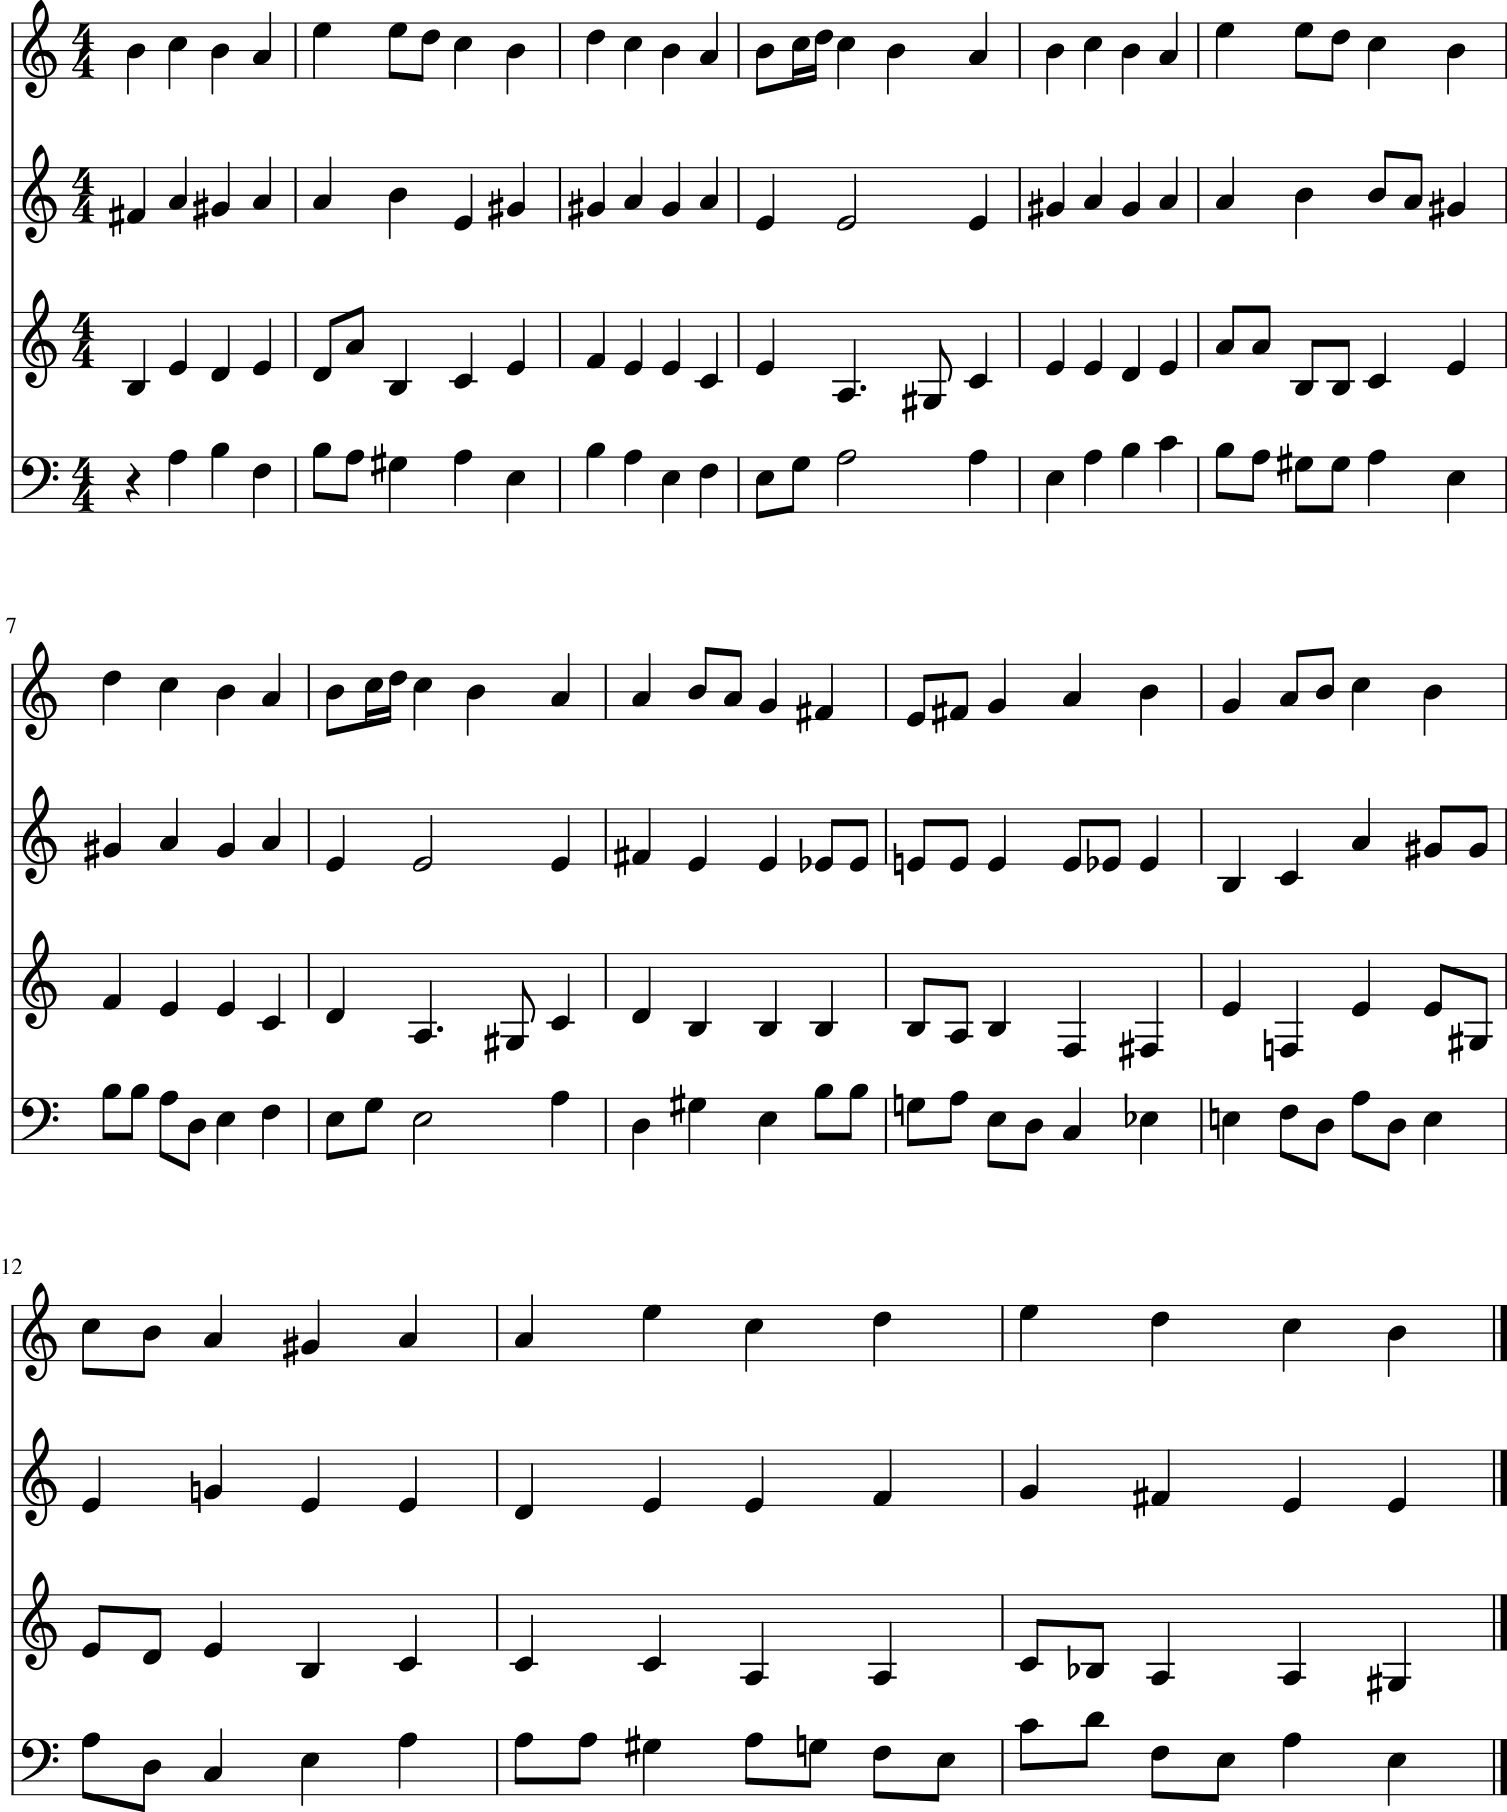

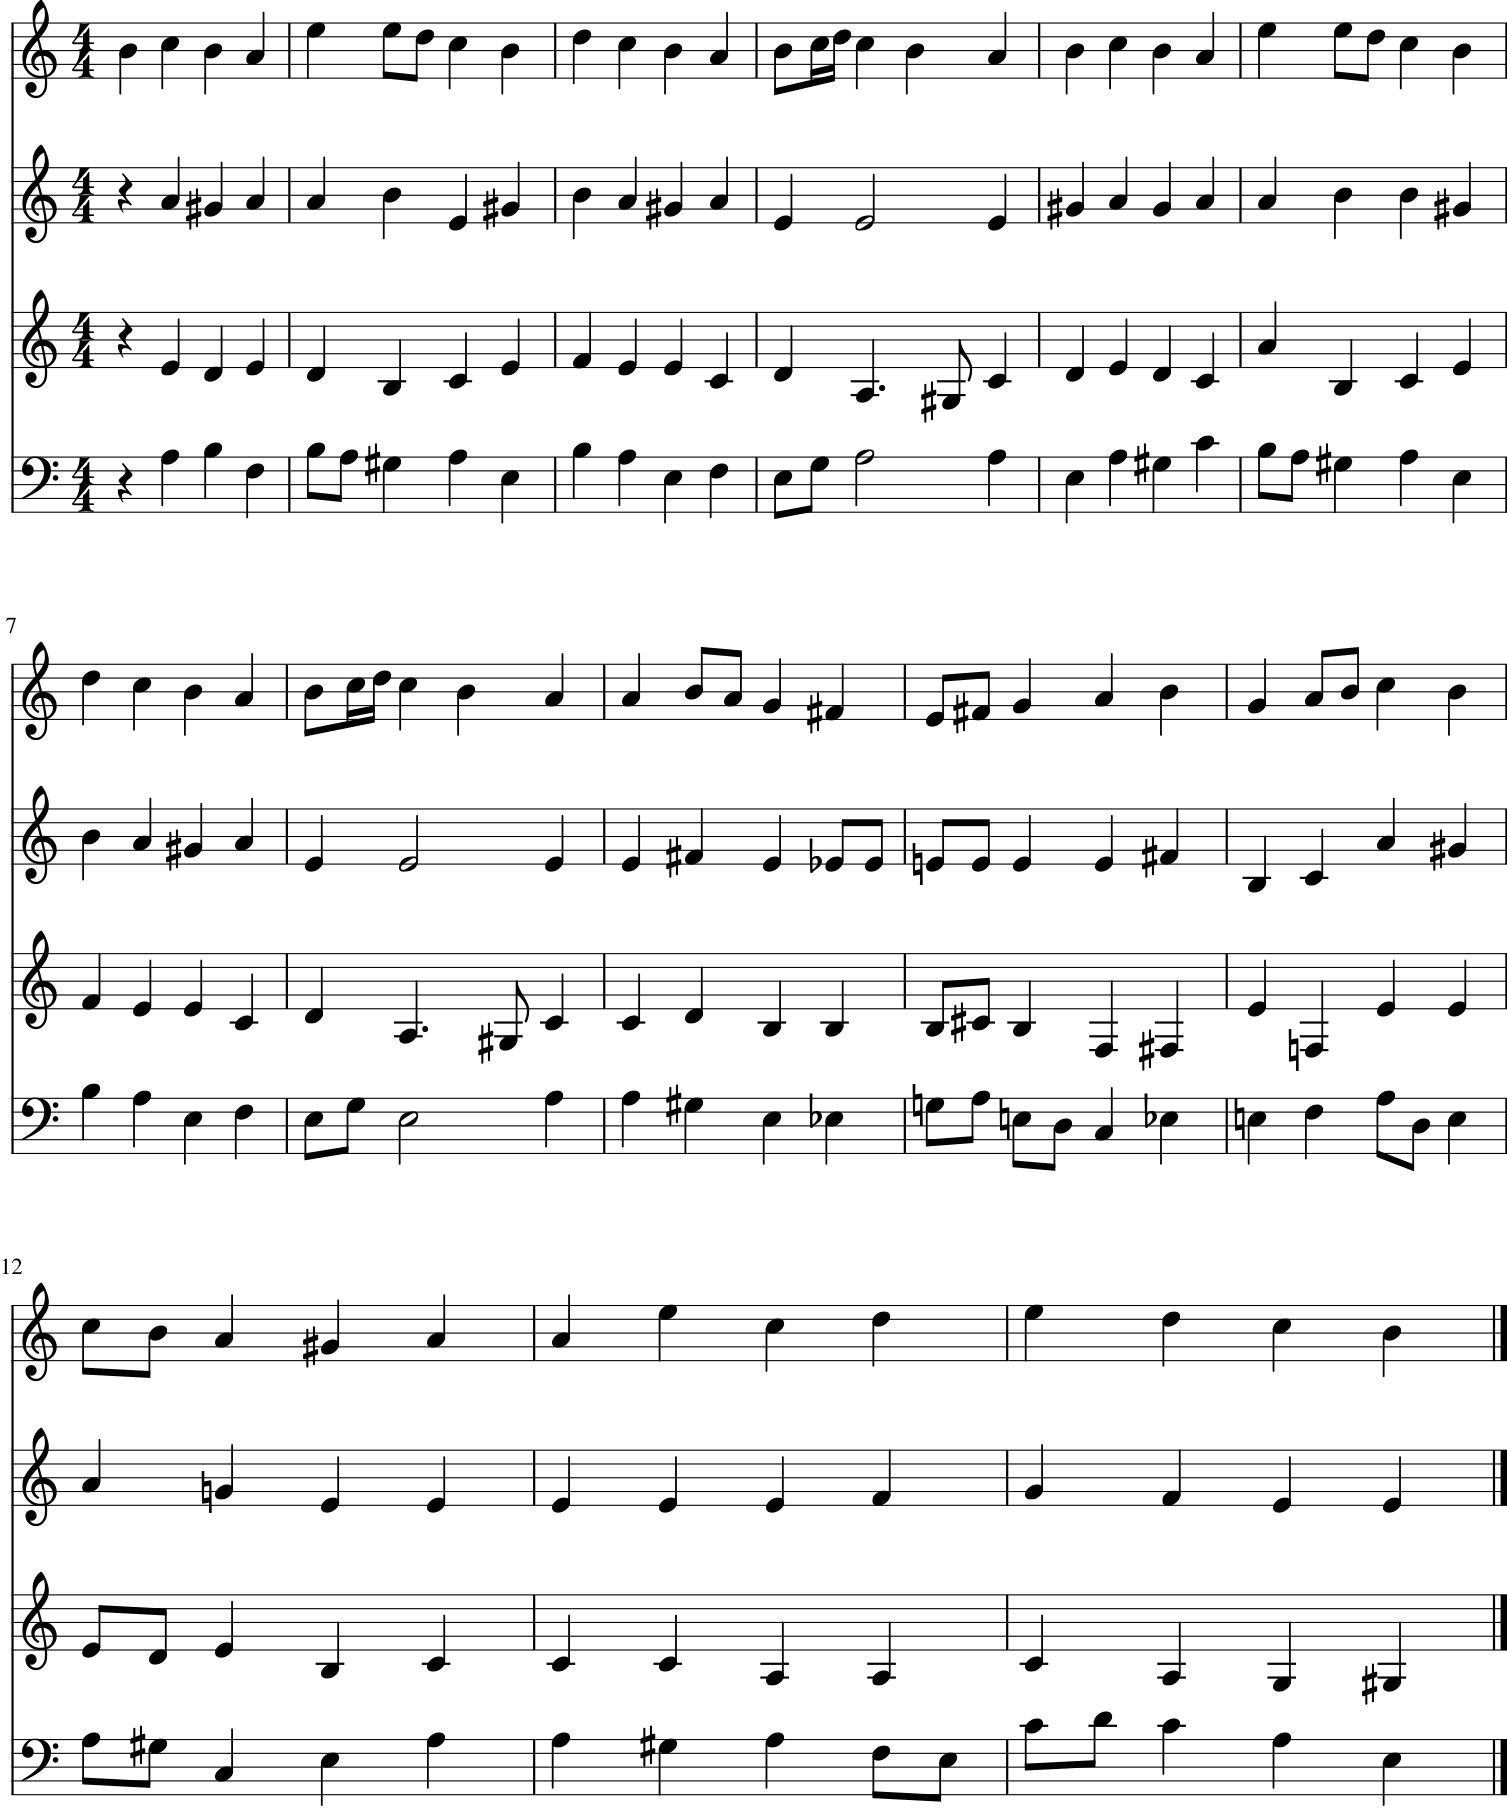

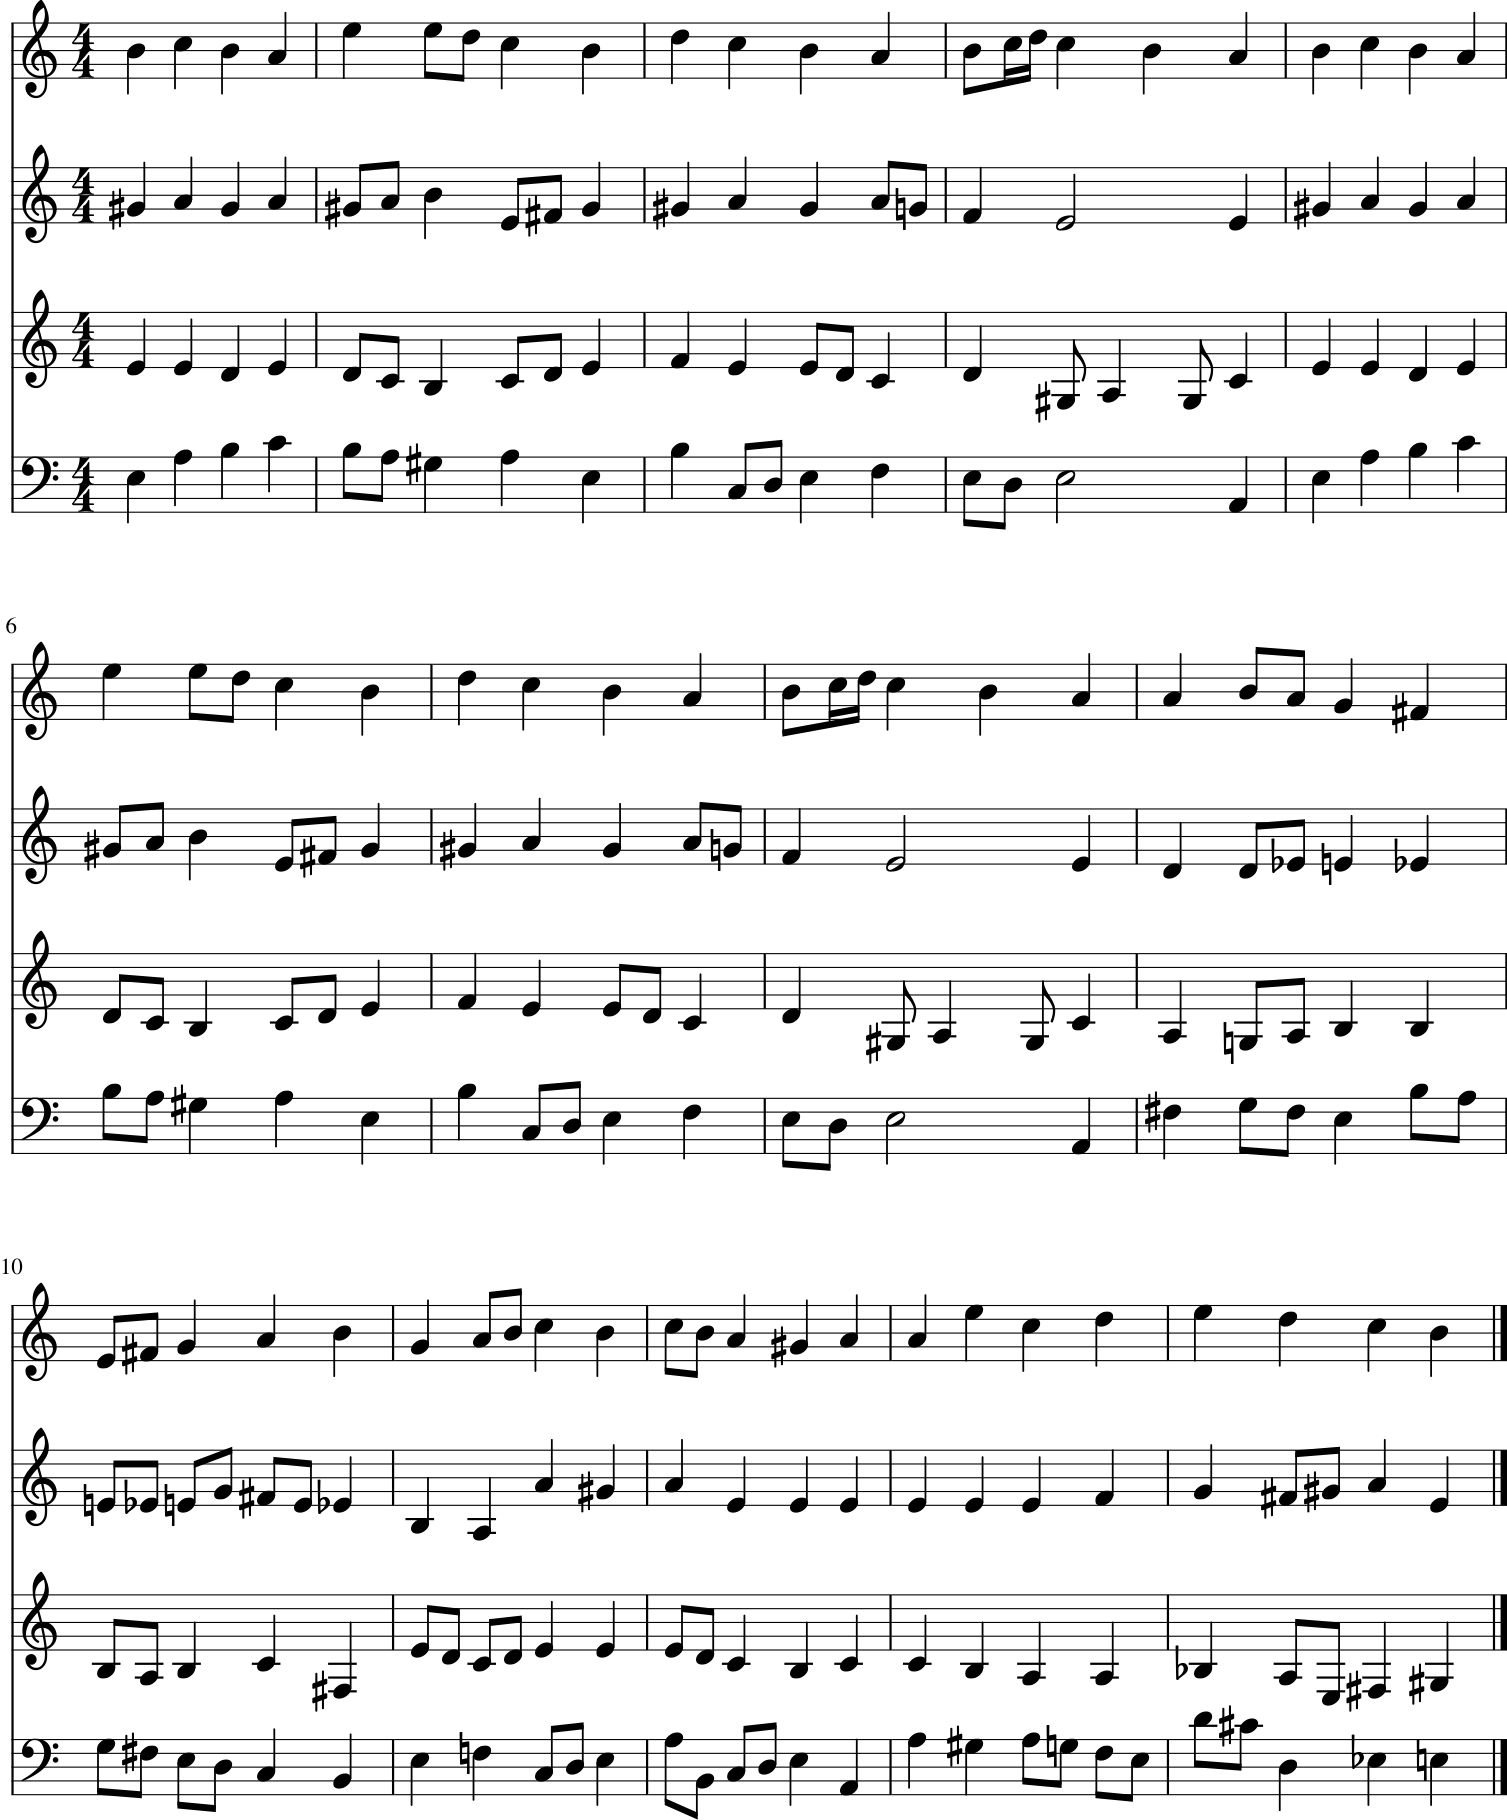

In [16]:
# 208 - 11 minor
# 190 3/4 major
songNum = 0
sc = createStream(predSongs[songNum], 4)
#print(sc.analyze('key'))
#sc.transpose(sc.analyze('key').sharps, inPlace = True)
sc.show()
sc.show('midi')
#sc.show('text')

sc = createStream(predSongsSmooth[songNum], 4)
#print(sc.analyze('key'))
#sc.transpose(sc.analyze('key').sharps, inPlace = True)
sc.show()
sc.show('midi')


sc = createStream(songs[songNum], 4)
sc.show()
sc.show('midi')



In [13]:
all_saver = tf.train.Saver()
all_saver.save(sess, '/home/lucky/models/208songsMajorMinor-Names')

'/home/lucky/models/208songsMajorMinor-Names'

In [ ]:
print(len(songs))

In [ ]:
all_saver = tf.train.Saver()
all_saver.restore(sess, "/home/lucky/models/98songs_4-4_4voicestrike")


In [ ]:
prediction_saver = tf.train.Saver([model.prediction])
predicition_saver.save(sess, '/home/lucky/models/208songsMajorMinor-2-prediction')

In [ ]:
for i in tf.global_variables():
    print(i)